In [1]:
library(ggplot2)
library(viridis)
library(dplyr)

plotfactors = function(location,exposures){
        exp1 = exposures/rowSums(exposures)
        exp1 = t(t(exp1)/colSums(exp1)) 
        plotdat = data.frame(x = location[,1], y = location[,2], all = exp1)

        datalong = reshape(plotdat, varying = colnames(plotdat)[-c(1,2)], direction = 'long', v.names = "prob")
        datalong$weight = datalong$prob
        qmax = quantile(datalong$weight, 0.95)
        datalong$weight[datalong$prob > qmax] = qmax


        g1 = ggplot(datalong, aes(x = x, y = y, col = weight))+
        geom_point(cex = 0.2)+ 
        facet_wrap(~time, ncol = 5)+ 
        theme(axis.text = element_blank(),
        axis.ticks=element_blank(), 
        axis.title = element_blank(), legend.position = "none")+
        scale_color_viridis()
        
        return(g1)

}

Loading required package: viridisLite

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



# Vizgen data

In [2]:
load("modelssaved/cellpose_f20_s5K_l500_norm.RData")


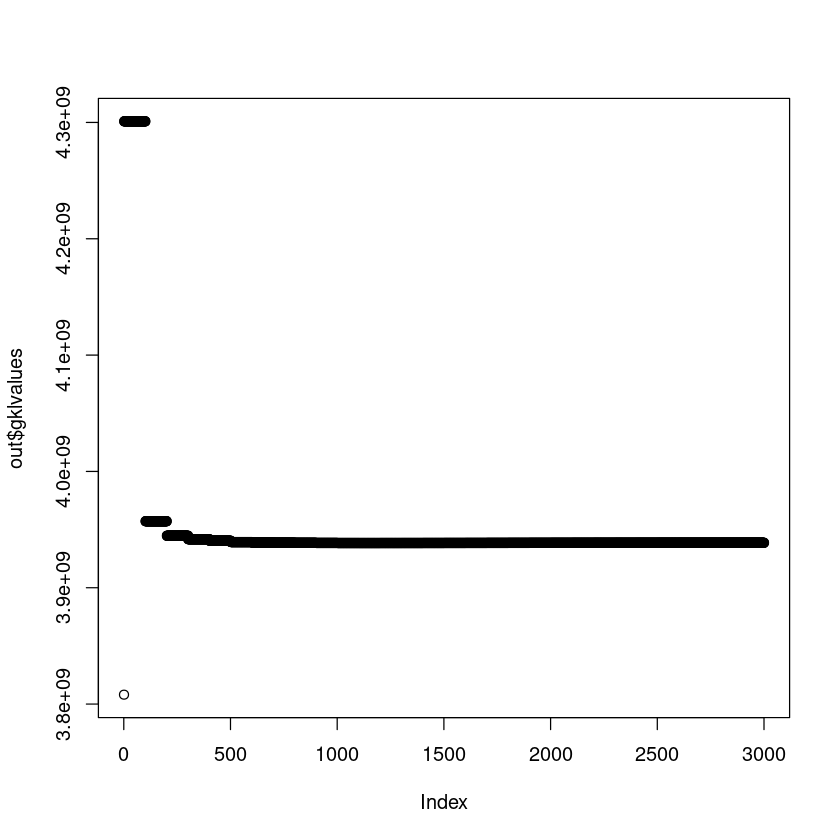

In [3]:

plot(out$gklvalues)



In [4]:
# get the genes
path1 = '/gladstone/engelhardt/pelka-collaboration/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/cellpose_cell_by_gene_goodgenes_noblanks.csv'
count = read.csv(path1, row.names = 1)
genes = colnames(count)
dim(count)

[1] 844468    492

In [5]:
# no gene count 
#no_count = read.csv('data/cell_no_gene_count.csv')[,2]
no_count = which(rowSums(count) < 20)

In [6]:
# load data for celltype plot
total = nrow(out$exposures) + length(no_count)
print(total)
celltype = rep("none",total)
cell_annotation = read.csv('data/midlevel_type.csv')

celltype[cell_annotation[,1] + 1] = as.character(cell_annotation[,2])

celltype = celltype[-no_count]
length(celltype)

[1] 844468


[1] 783549

In [7]:
path2 = '/gladstone/engelhardt/pelka-collaboration/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/cellpose_cell_metadata.csv'
metadata = read.csv(path2, row.names = 1)

location = metadata[,c('center_x','center_y')]
location = as.matrix(location)
print(nrow(location))
location = location[-no_count,]

[1] 844468


In [8]:

# subregion 1
#idx_sub = which( location[,1] > 41000 & location[,1] < 48000 &  location[,2] > 17500 & location[,2] < 24500)
#subregion 2
# idx_sub = which( location[,1] > 41000 & location[,1] < 48000 &  location[,2] > 30000 & location[,2] < 37000)
# subregion 3
#idx_sub = which( location[,1] > 36800 & location[,1] < 43800 &  location[,2] > 44000 & location[,2] < 51000)

# random
idx_sub = sample(length(celltype),50000)


In [9]:
exp_sub = out$exposures[idx_sub,]
celltype_sub = celltype[idx_sub]

In [10]:
location_sub = location[idx_sub,]
location_sub[,2] = -location_sub[,2]

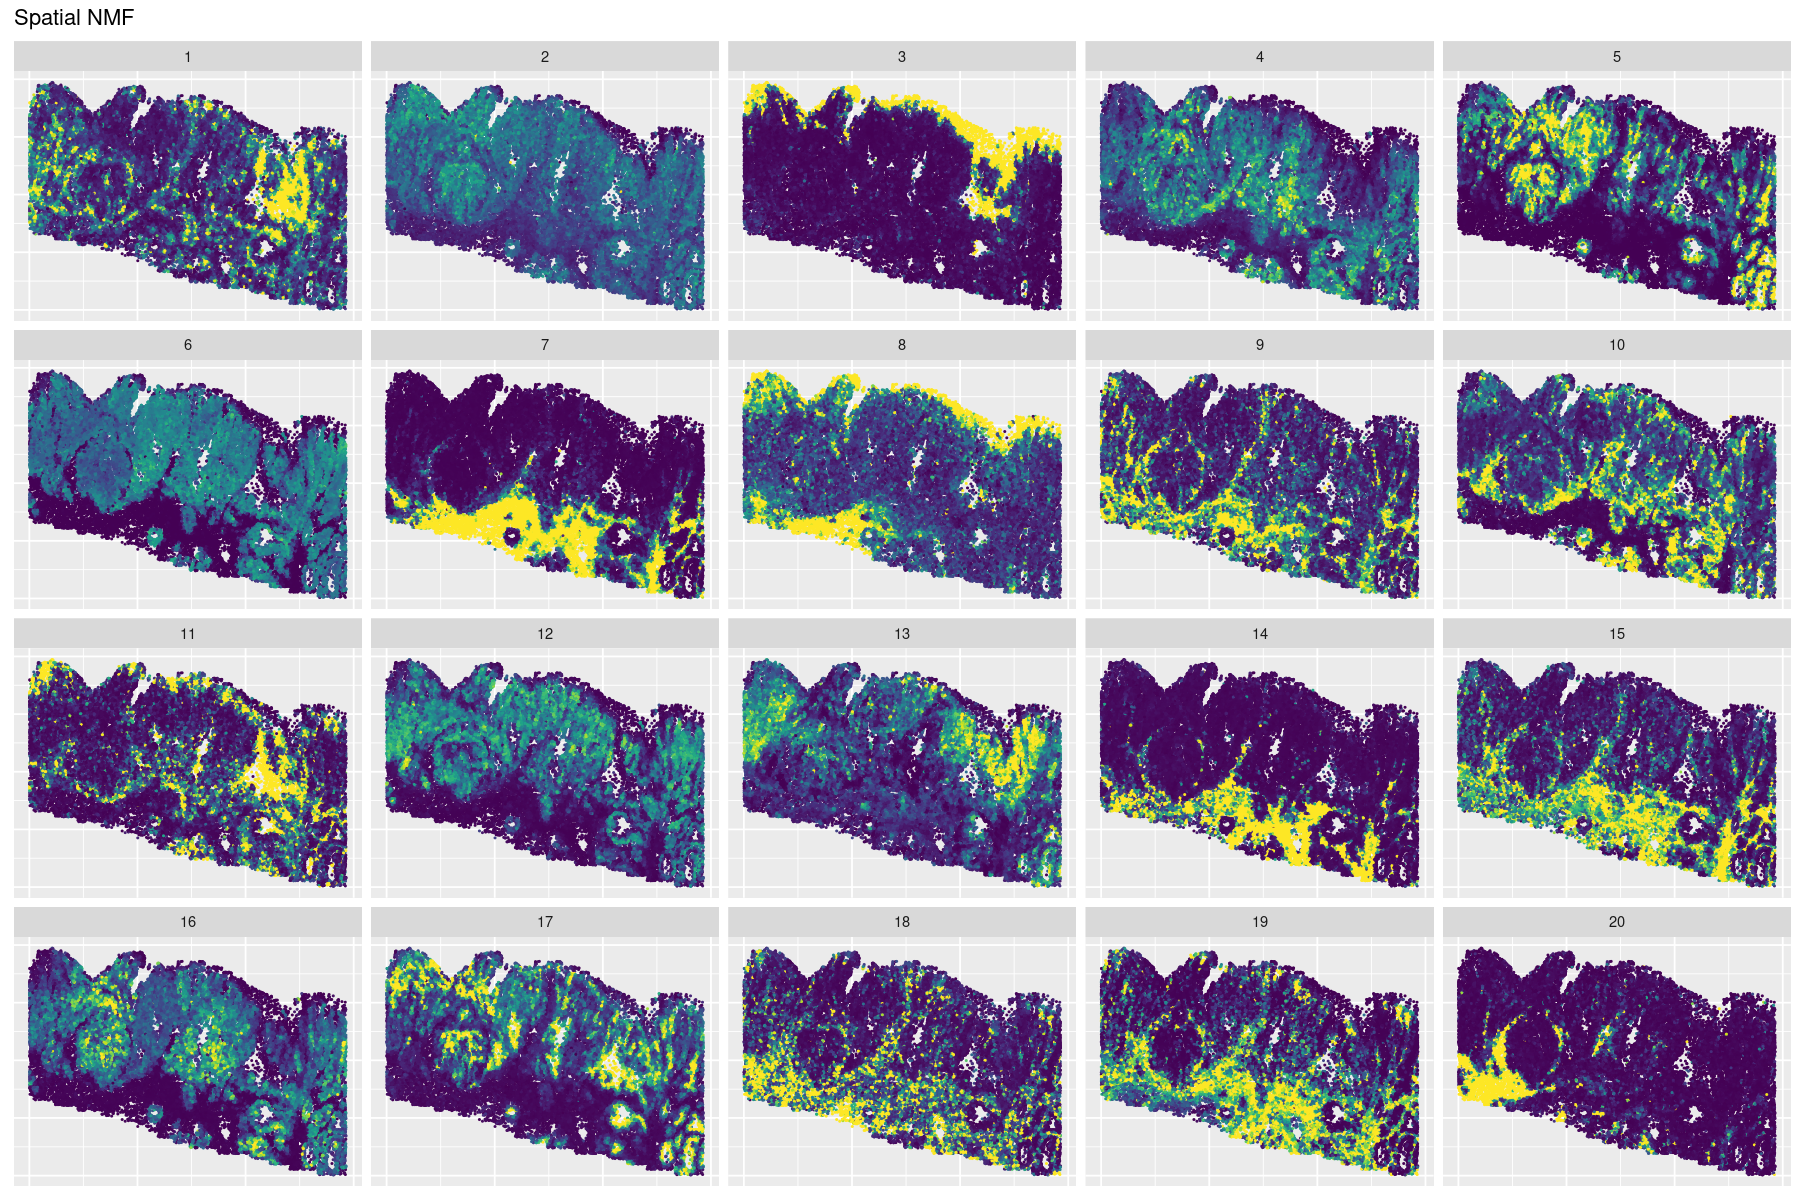

In [16]:
options(repr.plot.width=15, repr.plot.height=10)
plotfactors(location_sub,exp_sub) + ggtitle("Spatial NMF")

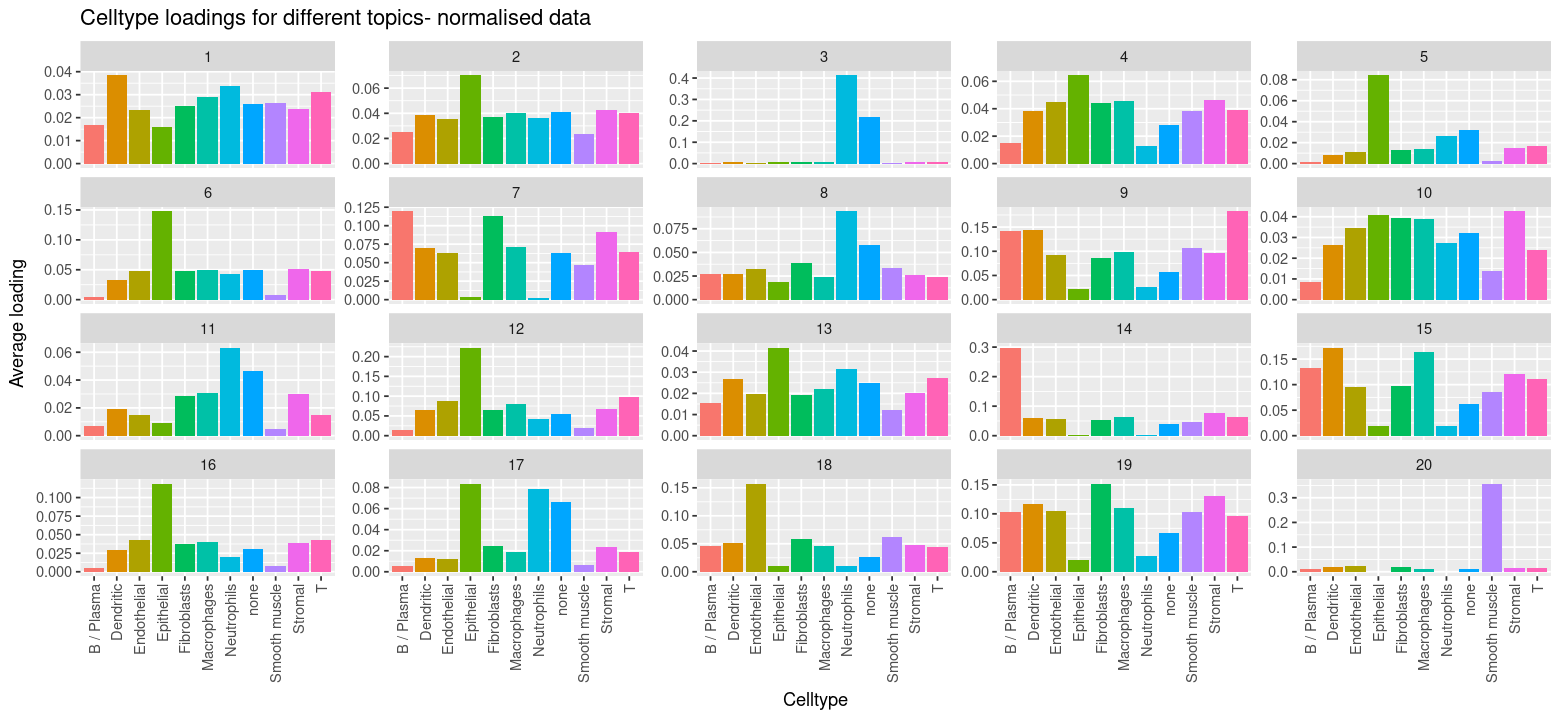

In [12]:
norm_exp = out$exposures/rowSums(out$exposures)

avg_big = function(x){ 
    y = x[x>1e-5]
     
    return(mean(y))
    }

cellmean = data.frame(norm_exp = norm_exp, Celltype = celltype) %>% group_by(Celltype) %>% summarise_at(paste0("norm_exp.",c(1:ncol(norm_exp))), avg_big)

#cellmean[,-1] = log(1 + cellmean[,-1]/rowSums(cellmean[,-1]))

cellmean_long = reshape(data.frame(cellmean), varying = colnames(cellmean)[-1], direction = 'long', v.names = "Avg_loading")

options(repr.plot.width=13, repr.plot.height=6)

ggplot(cellmean_long, aes(x = Celltype, fill = Celltype))+
geom_bar(aes(weight = Avg_loading))+
facet_wrap(~time, ncol = 5, scale = "free_y")+
theme(
axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
legend.position = "none")+
ylab("Average loading")+ggtitle("Celltype loadings for different topics- normalised data")

In [17]:
# Weighting from paper
dat = t(out$signatures)
dat_new=NULL
for(ii in 1:nrow(dat)){
  rr=dat[ii,]
  m1=max(rr)
  m2=max(rr[-which(rr==m1)])
  mm=rep(m1, length(rr))
  mm[which(rr==m1)]=m2
  ns=rr*log((rr+1e-10)/(mm+1e-10))
  dat_new=rbind(dat_new, ns)
}

weight_topgene = NULL
ng = 35
for(topic in 1:20){
    idx = order(dat_new[,topic], decreasing = T)
    weighting = genes[idx[1:ng]]

    weight_topgene = rbind(weight_topgene,c(topic,weighting))

}
#write.csv(data.frame(weight_topgene), "resultplots/topgenes_cellpose_regnmf.csv", row.names=FALSE)
weight_topgene[7,]

[1] "7"       "SFRP2"   "FBLN1"   "TGFB3"   "MFAP5"   "SMOC2"   "PLA2G2A"
 [8] "PDGFRA"  "CXCL12"  "VEGFB"   "WWTR1"   "MMP2"    "LOX"     "IGF1"   
[15] "ROR1"    "IL17A"   "KLRF1"   "IL13"    "FLI1"    "FGFBP2"  "IL12B"  
[22] "IDO2"    "IFNB1"   "EGF"     "IL5RA"   "CD1B"    "CCR6"    "LGR5"   
[29] "CD177"   "KIR2DL4" "SH2D1B"  "NCR3"    "CR2"     "NCR1"    "IL1R2"  
[36] "STAP1"

In [19]:
# More distinct genes
dat = t(out$signatures)
dat_new=NULL
for(ii in 1:nrow(dat)){
  rr=dat[ii,]
  m1=max(rr)
  m2=max(rr[-which(rr==m1)])
  mm=rep(m1, length(rr))
  mm[which(rr==m1)]=m2
  ns=rr/mm
  dat_new=rbind(dat_new, ns)
}

weight_topgene = NULL
ng = 15
for(topic in 1:20){
    idx = order(dat_new[,topic], decreasing = T)
    weighting = genes[idx[1:ng]]

    weight_topgene = rbind(weight_topgene,c(topic,weighting))

}

weight_topgene

#write.csv(data.frame(weight_topgene), "resultplots/topgenes_cellpose_l500_distinct.csv", row.names=FALSE)


[,1] [,2]     [,3]    [,4]    [,5]    [,6]     [,7]   [,8]     [,9]    
 [1,] 1    CXCL10   IDO1    CXCL11  CXCL9   CCL22    CD274  LAMP3    CX3CL1  
 [2,] 2    PKM      LDHA    MAP2K1  CD207   KLRC1    HRAS   HDAC1    IFNB1   
 [3,] 3    FFAR2    IL1B    CSF3R   PTGS2   SOCS3    PROK2  CXCR1    CXCL8   
 [4,] 4    TGFBI    TGFBR2  CTNNB1  TBK1    RB1      PIK3CA TBX10    SMAD2   
 [5,] 5    NDUFA4L2 SLC26A3 NEDD4   PKIB    TMEM37   EPCAM  IFNGR2   CA9     
 [6,] 6    SOX9     WNT3    YAP1    CEACAM8 TCF7L2   DUSP6  CDH1     SHARPIN 
 [7,] 7    SFRP2    FBLN1   MFAP5   SMOC2   MMP2     CXCL12 PDGFRA   PLA2G2A 
 [8,] 8    EGR1     FOS     JUNB    ATF3    IL22     DUSP1  JUN      CD1B    
 [9,] 9    TRAC     CD2     CD3E    FOXP3   TIGIT    IL2RB  ITK      CCR4    
[10,] 10   LAMC2    LAMB3   EPHA2   FGF2    ZBED2    DKK1   MET      EGFR    
[11,] 11   SPP1     MMP12   MMP9    CXCL5   MARCO    IL6    SERPINE1 WNT5A   
[12,] 12   MKI67    FOXM1   BIRC5   PLK1    CCNB1    MCM2   CHEK1    BRCA1   
[13,] 13   NOS2     MUC1    HLA.B   CSF3    MPO      TGFB2  LGALS9   SERPINA1
[14,] 14   MZB1     CD79A   POU2AF1 DERL3   FCRL5    IRF4   XBP1     CD27    
[15,] 15   C1QC     CYBB    TREM2   CSF1R   HLA.DPB1 FCGR3A CD163    MRC1    
[16,] 16   EPHB3    AXIN2   ASCL2   CCR6    PRKCA    TSC1   LRP6     AKT2    
[17,] 17   VEGFA    DDIT3   ROS1    TNFSF9  RELA     TBX3   BRD4     PMS2    
[18,] 18   PLVAP    VWF     CDH5    PGF     CLEC14A  FLT4   MMRN2    KDR     
[19,] 19   COL5A1   FN1     MMP11   CCL26   COL11A1  TWIST1 SNAI2    CD1E    
[20,] 20   DES      MYH11   TNC     FGFR2   WNT3A    ACTA2  HGF      NCAM1   
      [,10]  [,11]  [,12]   [,13]   [,14]     [,15]   [,16] 
 [1,] CCL17  SOD2   NFKB2   NFKB1   STAT1     TNF     CXCL1 
 [2,] CD70   CCR3   LMNA    MUC4    MTOR      EGF     AKT1  
 [3,] ITGAX  CXCR2  PGLYRP1 CCR10   S100A9    IL3RA   IL6R  
 [4,] IFNAR1 BMI1   CASP8   NRAS    MSH3      BRAF    PTEN  
 [5,] FABP2  FZD7   PLOD2   CDKN1A  CEACAM1   NFE2L2  LRP1  
 [6,] LGR6   MYC    TEAD4   IFNGR1  EPHB4     BRD4    CD276 
 [7,] TGFB3  ROR1   VEGFB   IGF1    LOX       WWTR1   CX3CR1
 [8,] IL5RA  IL1R2  SOX2    IL12B   IKZF4     XCL1    ELANE 
 [9,] TRBC1  ZAP70  CD28    ICOS    CXCR6     PDCD1   KLRB1 
[10,] BCL2L1 FOSL1  TEAD1   GPX3    AMOTL2    PDGFA   ITGB1 
[11,] CEBPB  CCL2   IL4I1   KIR3DL2 CCL3      MMP1    CCL7  
[12,] PCNA   AURKA  AURKB   MCM6    EZH2      MYBL2   MSH2  
[13,] IL21   TAPBP  HLA.C   BTLA    KIR2DL4   STAT3   BAK1  
[14,] CD79B  VSIR   IFNAR2  CD19    TNFRSF13C STAP1   ICAM3 
[15,] CD209  TLR1   CMKLR1  MAFB    HLA.DQA1  CD14    LYZ   
[16,] LRP5   LEF1   DNMT3A  CDK6    LGR5      APC     MAML1 
[17,] PPARD  STAT6  TCF7L2  CA7     JUN       CEACAM1 PDK1  
[18,] CLDN5  ANGPT2 ENG     TEK     FLT1      PREX2   NOS3  
[19,] COL1A1 FAP    FGF1    COL6A3  CLCA1     TNFSF4  PDGFRB
[20,] CTSG   ELN    ITGA5   KIT     CCL11     RGMB    IRS1

In [ ]:
data.frame(celltype = celltype[idx_20],cell_count = cell_count[idx_20]) %>% group_by(celltype) %>% summarise(cell_mean = median(cell_count))

celltype      cell_mean
1  B / Plasma    331.0    
2  Dendritic     333.5    
3  Endothelial   424.0    
4  Epithelial    517.0    
5  Fibroblasts   295.0    
6  Macrophages   344.0    
7  Neutrophils    76.0    
8  none           28.0    
9  Smooth muscle 160.0    
10 Stromal        98.0    
11 T             261.0

In [ ]:
ggplot(data.frame(celltype,cell_count), aes(x = cell_count))+
geom_histogram()+ 
facet_wrap(~celltype)

ERROR: Error in ggplot(data.frame(celltype, cell_count), aes(x = cell_count)): could not find function "ggplot"


In [53]:
library(pals)

ERROR: Error in library(pals): there is no package called ‘pals’


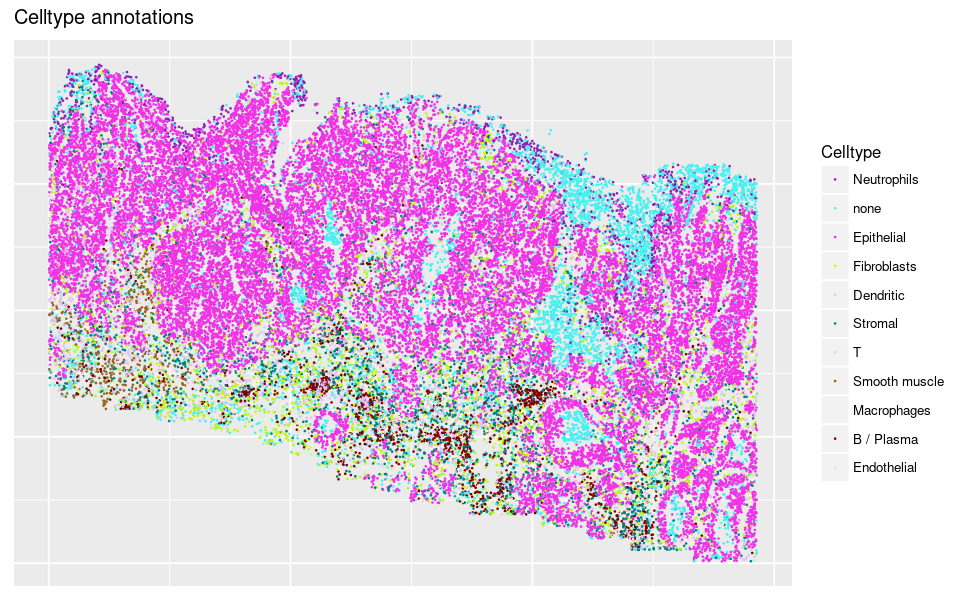

In [17]:
myCol = c('#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000')

options(repr.plot.width=8, repr.plot.height=5)
dat1 = data.frame(x = location_sub[,1], y = location_sub[,2], Celltype = celltype_sub)
dat1$Celltype = factor(dat1$Celltype, levels = unique(dat1$Celltype))
ggplot(dat1, aes(x = x, y = y, color = Celltype))+
        geom_point(cex = 0.1, alpha = 1)+
        #facet_wrap(~type)+
        theme(text = element_text(size = 10), 
        axis.text = element_blank(),
        axis.ticks=element_blank(), 
        axis.title = element_blank()
        )+
        ggtitle("Celltype annotations")+
        scale_color_manual(values=myCol[6:16])
        

In [55]:
sum(celltype == 'Epithelial cells')

[1] 516739

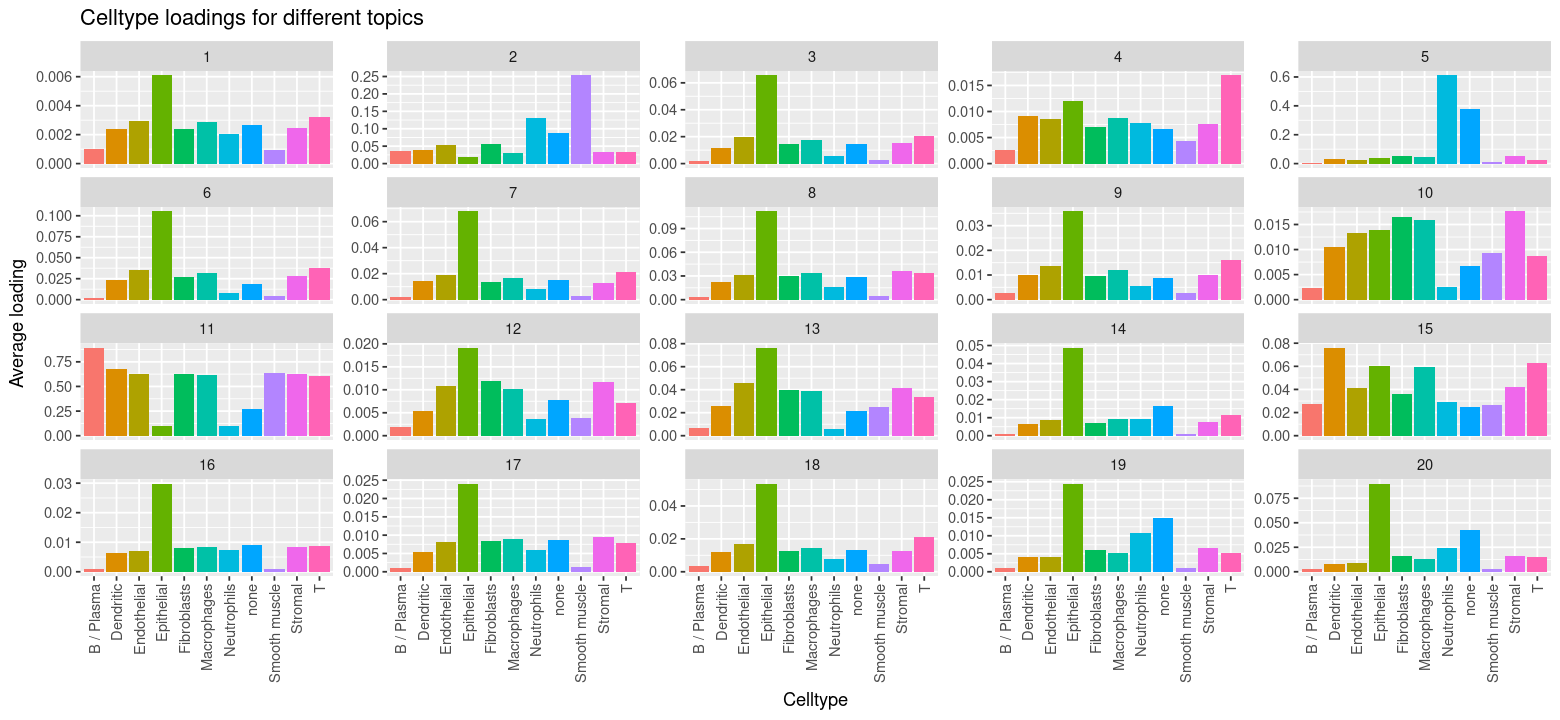

In [ ]:
norm_exp = out$exposures/rowSums(out$exposures)

cellmean = data.frame(norm_exp = norm_exp, Celltype = celltype) %>% group_by(Celltype) %>% summarise_at(paste0("norm_exp.",c(1:ncol(norm_exp))), mean)


cellmean_long = reshape(data.frame(cellmean), varying = colnames(cellmean)[-1], direction = 'long', v.names = "Avg_loading")

options(repr.plot.width=13, repr.plot.height=6)

ggplot(cellmean_long, aes(x = Celltype, fill = Celltype))+
geom_bar(aes(weight = Avg_loading))+
facet_wrap(~time, ncol = 5, scale = "free_y")+
theme(
axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
legend.position = "none")+
ylab("Average loading")+ggtitle("Celltype loadings for different topics")

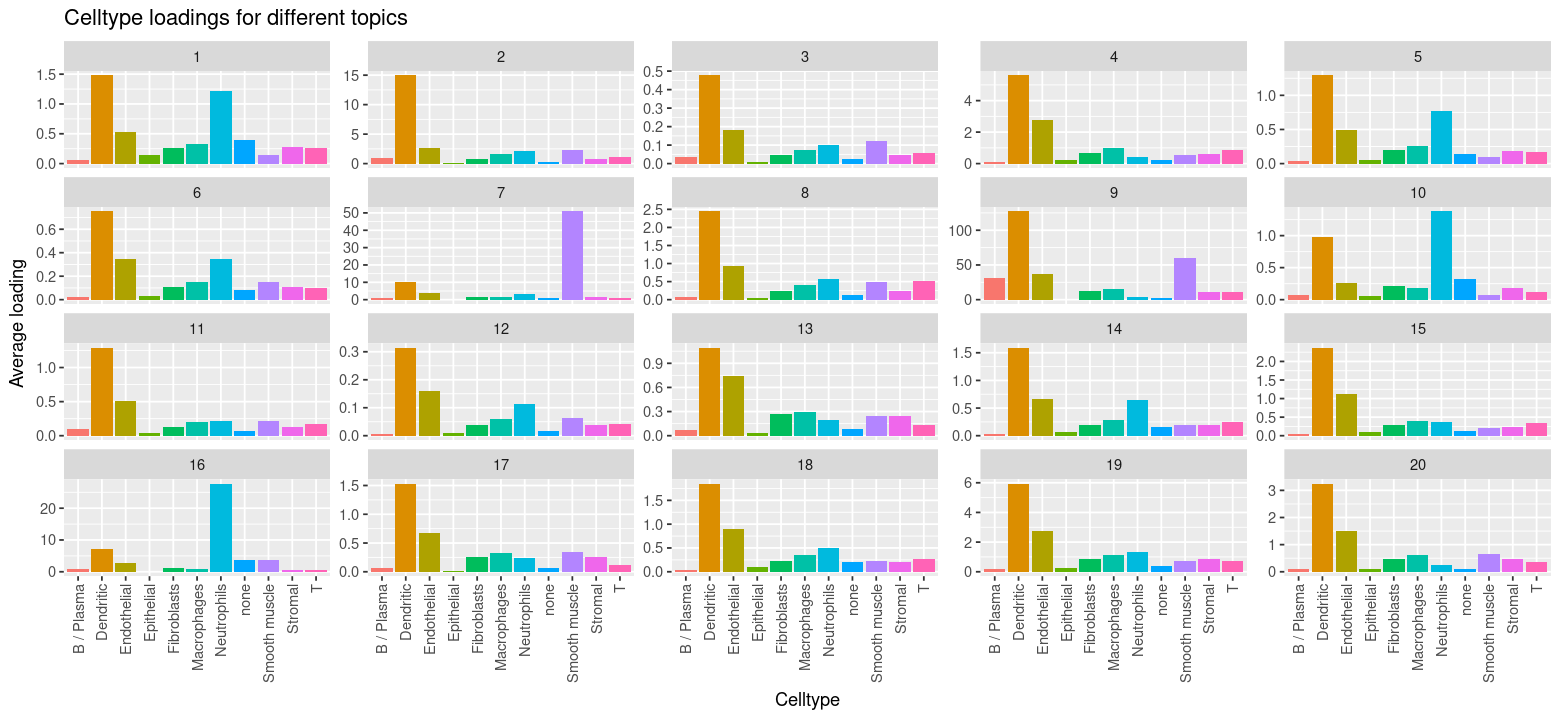

In [ ]:
norm_exp = out$exposures/rowSums(out$exposures)

cellmean = data.frame(norm_exp = norm_exp, Celltype = celltype) %>% group_by(Celltype) %>% summarise_at(paste0("norm_exp.",c(1:ncol(norm_exp))), function(x) mean(x)/(length(x)/nrow(norm_exp)))

#cellmean[,-1] = log(1 + cellmean[,-1]/rowSums(cellmean[,-1]))

#exp_dat_long = reshape(exp_dat, varying = colnames(exp_dat)[-1], direction = 'long', v.names = "Avg_loading")

#avg_mat = exp_dat_long %>% group_by(Celltype) %>% mutate(cell_avg = Avg_loading/sum(Avg_loading))
#avg_mat2 = avg_mat %>% group_by(Celltype, time) %>% summarise(fraction = median(cell_avg))

cellmean_long = reshape(data.frame(cellmean), varying = colnames(cellmean)[-1], direction = 'long', v.names = "Avg_loading")

options(repr.plot.width=13, repr.plot.height=6)

ggplot(cellmean_long, aes(x = Celltype, fill = Celltype))+
geom_bar(aes(weight = Avg_loading))+
facet_wrap(~time, ncol = 5, scale = "free_y")+
theme(
axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
legend.position = "none")+
ylab("Average loading")+ggtitle("Celltype loadings for different topics")

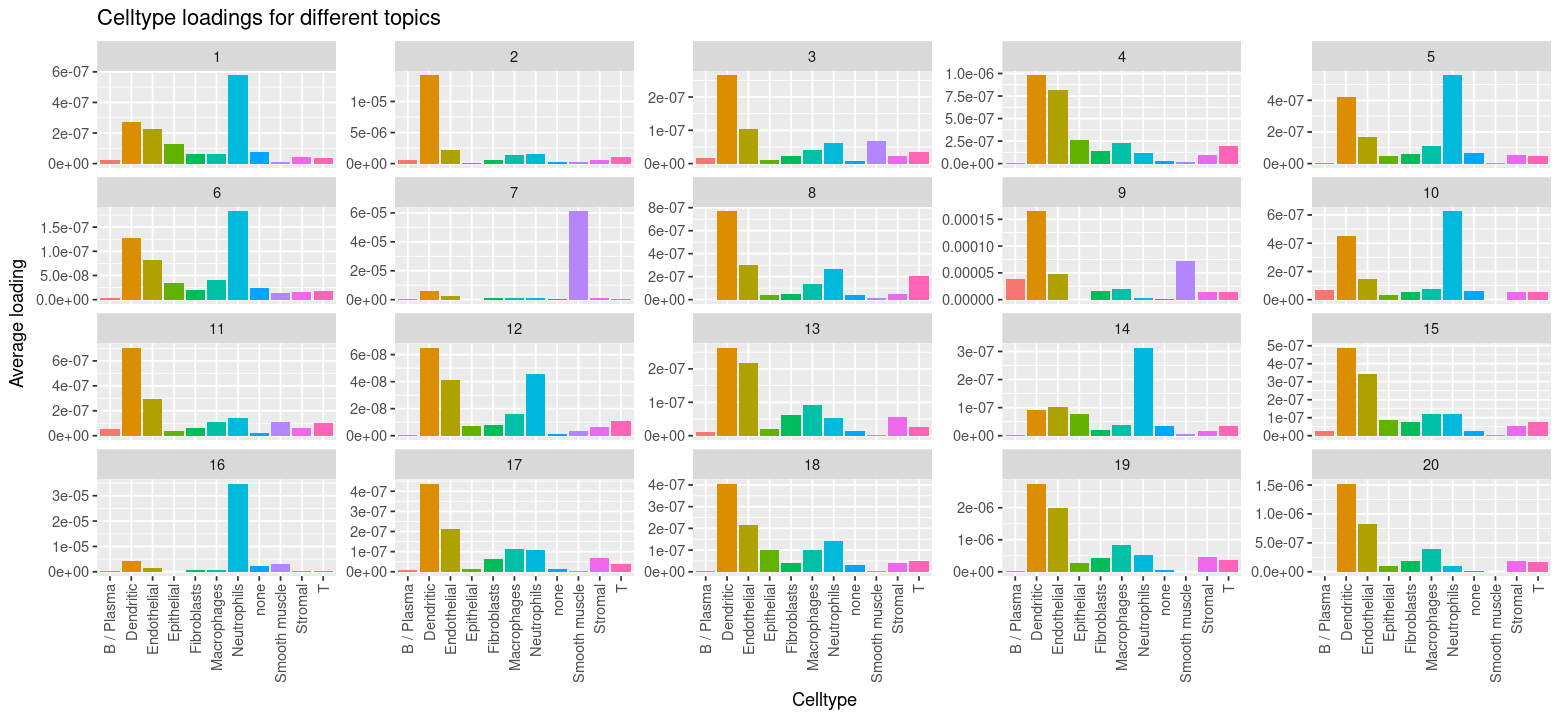

In [ ]:
norm_exp = out$exposures/rowSums(out$exposures)

exp_dat = data.frame(Celltype = celltype, norm_exp = norm_exp)

exp_dat_long = reshape(exp_dat, varying = colnames(exp_dat)[-1], direction = 'long', v.names = "Avg_loading")

avg_mat = exp_dat_long %>% group_by(Celltype) %>% mutate(cell_avg = Avg_loading/sum(Avg_loading))
avg_mat2 = avg_mat %>% group_by(Celltype, time) %>% summarise(fraction = median(cell_avg))


options(repr.plot.width=13, repr.plot.height=6)

ggplot(avg_mat2, aes(x = Celltype, fill = Celltype))+
geom_bar(aes(weight = fraction))+
facet_wrap(~time, ncol = 5, scale = "free_y")+
theme(
axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
legend.position = "none")+
ylab("Average loading")+ggtitle("Celltype loadings for different topics")

In [ ]:
orderindex = celltype_sub
norm_exp = exp_sub/rowSums(exp_sub)
for( x in 1:ncol(exp_sub)){
    orderindex = paste0(orderindex,round(norm_exp[,x],2))
}
orderindex = paste0(orderindex, 1:length(orderindex))
plotdat = data.frame(index = orderindex,celltype = celltype_sub, all = norm_exp)

datalong = reshape(plotdat, varying = colnames(plotdat)[-c(1:2)], direction = 'long', v.names = "prob")

datalong$topic = factor(datalong$time)

In [ ]:
myCol = c("pink1", "mediumpurple1", "purple3",
          "turquoise2", "skyblue", "steelblue", "blue2", "navyblue",
          "orange", "tomato", "coral2", "palevioletred", "violetred", "red2",
          "springgreen2", "yellowgreen", "palegreen4", "tan3", "brown",
          "grey70")

length(myCol)

[1] 20

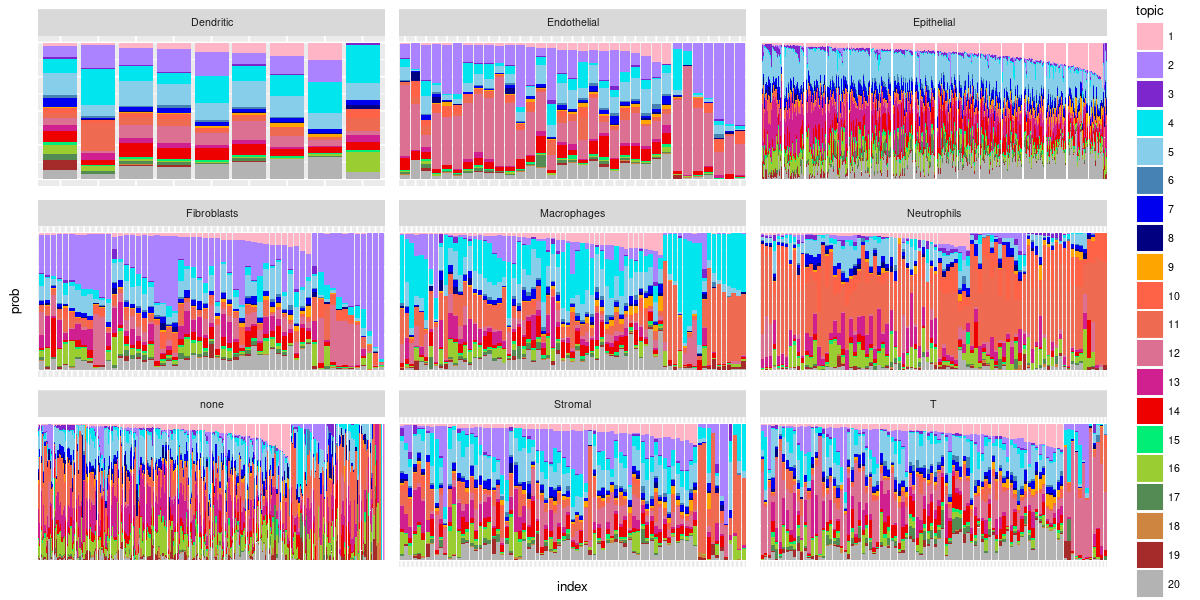

In [ ]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot(datalong, aes(x = index, y = prob, fill = topic))+
         geom_bar(position="stack", stat="identity")+
         theme(axis.text = element_blank(),
         axis.ticks=element_blank(), 
         text = element_text(size = 8))+
         facet_wrap(~celltype, scale = "free")+
         scale_fill_manual(values=myCol)
